In [80]:
DATA_PATH = '/root/Internship-Valeo/Project/data/COCO/'

In [113]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow_addons.image import transform as H_transform
import os
from models.utils import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
from models.homographies import *
from utils.tools import dict_update

In [82]:
train_images = os.listdir(DATA_PATH+'anntrain2014')
val_images = os.listdir(DATA_PATH+'annval2014')
mask_train_images = os.listdir(DATA_PATH+'anntrain2014')
mask_val_images = os.listdir(DATA_PATH+'annval2014')

In [83]:
image_shape = (240, 320,1)

In [84]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.001, # 1/65
            'descriptor_size': 256,
            'batch_size': 64,
            'epochs': 25,
            'learning_rate': 0.001,
            'kernel_reg': 0.,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 4,
            'top_k': 0
    }

In [85]:
def net():
    
    images_input = Input(shape = (240, 320,1), name = 'images_input')
    
    encoder = shared_encoder(model_config = model_config)
    encoder_output = encoder(images_input)
    
    detector = detector_head(model_config = model_config)
    detector_output = detector(encoder_output)
    
    model = keras.models.Model(inputs = images_input, outputs = detector_output)
    return model

In [86]:
model = net()

In [87]:
model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-no_aug')

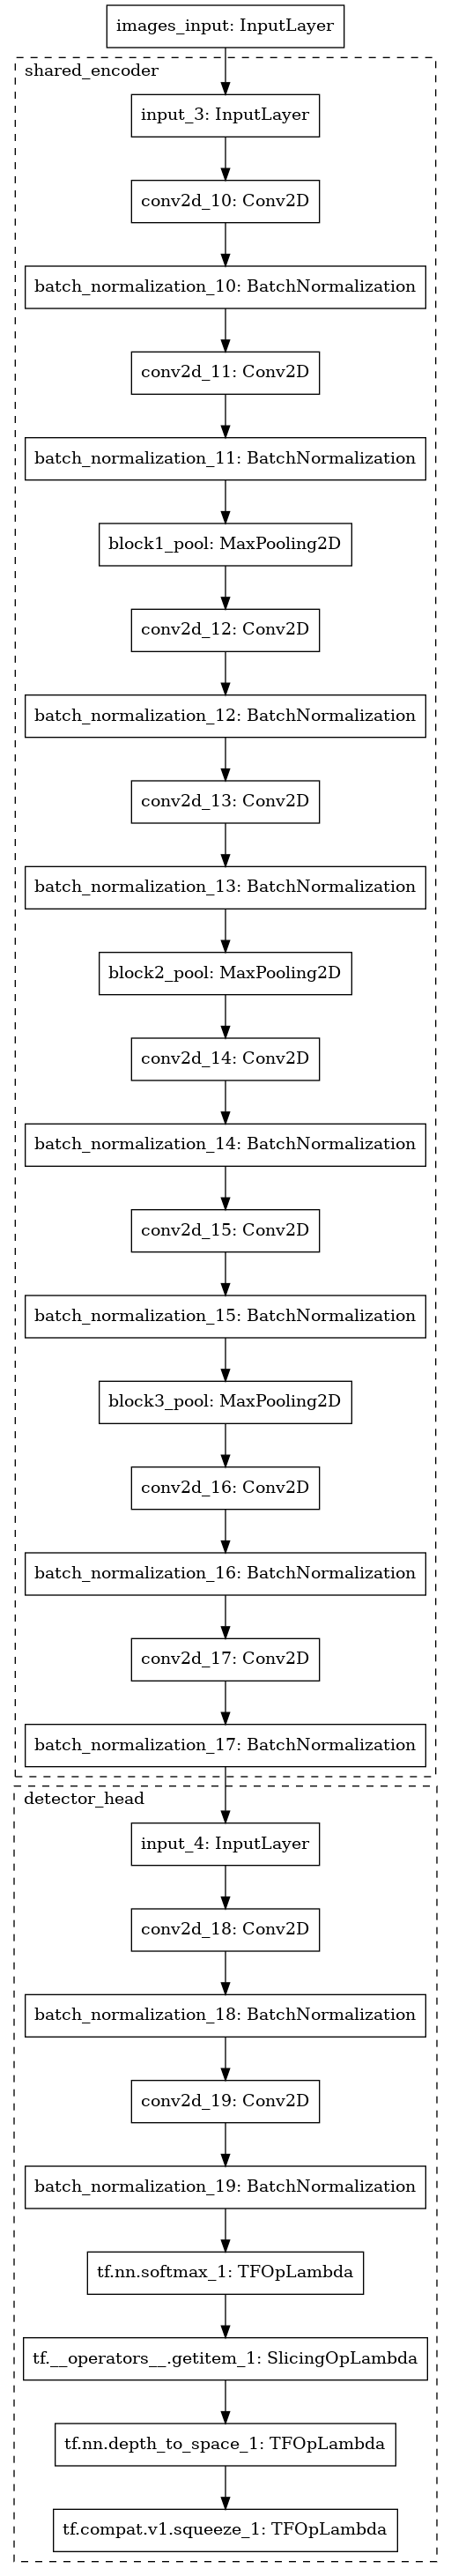

In [88]:
keras.utils.plot_model(model, rankdir="TB", expand_nested=True)

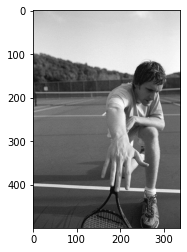

In [89]:
I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',train_images[0]),0)
plt.imshow(I, cmap = 'gray')

In [90]:
I.shape

(500, 339)

In [91]:
I = cv2.resize(I,(320, 240))
I = np.expand_dims(I, axis = 0)
I = np.expand_dims(I, axis = 3)

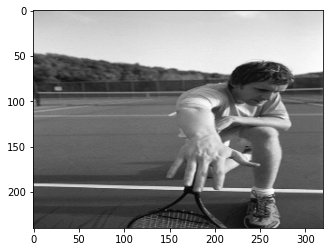

In [92]:
plt.imshow(I[0], cmap = 'gray')

In [93]:
result = model.predict(I)
result['logits'].shape

(1, 30, 40, 65)

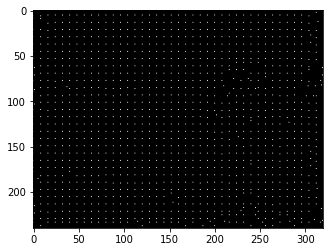

In [117]:
cfirst = model_config['data_format'] == 'channels_first'
cindex = 1 if cfirst else -1  # index of the channel
labels = tf.argmax(result['logits'], axis =cindex)
one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
# Strip the extra “no interest point” dustbin
one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
one_hot = tf.nn.depth_to_space(
              one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
one_hot = tf.squeeze(one_hot, axis=cindex)

plt.imshow((one_hot)[0], cmap = 'gray')

In [124]:
np.argwhere(one_hot[0])

array([[  2, 312],
       [  5,  16],
       [  5,  24],
       ...,
       [237, 256],
       [237, 264],
       [237, 288]])

# Detections on train images without homographic adaptation

In [ ]:
# Repeat when a detector has been trained again

for file_path in train_images:
    I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',file_path),0)
    I = cv2.resize(I,(320, 240))
    I = np.expand_dims(I, axis = 0)
    I = np.expand_dims(I, axis = 3)
    result = model.predict(I)
    
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    labels = tf.argmax(result['logits'], axis =cindex)
    one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
    # Strip the extra “no interest point” dustbin
    one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
    one_hot = tf.nn.depth_to_space(
              one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    one_hot = tf.squeeze(one_hot, axis=cindex)
    np.save(os.path.join(DATA_PATH, 'pointstrain2014',file_path), one_hot[0])

# Detections on val images without homographic adaptation

In [17]:
# Repeat when a detector has been trained again

for file_path in val_images:
    I = cv2.imread(os.path.join(DATA_PATH, 'annval2014',file_path),0)
    I = cv2.resize(I,(320, 240))
    I = np.expand_dims(I, axis = 0)
    I = np.expand_dims(I, axis = 3)
    result = model.predict(I)
    
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    labels = tf.argmax(result['logits'], axis =cindex)
    one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
    # Strip the extra “no interest point” dustbin
    one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
    one_hot = tf.nn.depth_to_space(
              one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    one_hot = tf.squeeze(one_hot, axis=cindex)
    np.save(os.path.join(DATA_PATH, 'pointsval2014',file_path), one_hot[0])

# Homographic Adaptation (not sure if it's working)

In [48]:
cfirst = model_config['data_format'] == 'channels_first'
cindex = 1 if cfirst else -1  # index of the channel

HA = homography_adaptation(I, model)

In [49]:
HA = np.expand_dims(HA['mean_prob'], axis = 3)
HA = tf.nn.space_to_depth(HA, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')

In [50]:
np.max(np.sum(HA, axis = 3))

1.2216948

# Save homographies

In [52]:
config = {
            'add_augmentation_to_test_set': False,
            'num_parallel_calls': 10,
            'preprocessing': {
                'resize': [240, 320],
                'blur_size': 11,
            },
            'augmentation': {
                'photometric': {
                    'enable': True,
                    'primitives': 'all',
                    'params': {
                        'random_brightness': {'max_abs_change': 75},
                        'random_contrast': {'strength_range': [0.3, 1.8]},
                        'additive_gaussian_noise': {'stddev_range': [0, 15]},
                        'additive_speckle_noise': {'prob_range': [0, 0.0035]},
                        'additive_shade':{
                            'transparency_range': [-0.5, 0.8],
                            'kernel_size_range': [50, 100]},
                        'motion_blur': {'max_kernel_size': 7}},
                    'random_order': True,
                },
                'homographic': {
                    'enable': True,
                    'params': {
                        'translation': True,
                        'rotation': True,
                        'scaling': True,
                        'perspective': True,
                        'scaling_amplitude': 0.2,
                        'perspective_amplitude_x': 0.2,
                        'perspective_amplitude_y': 0.2,
                        'patch_ratio': 0.8,
                        'max_angle': 1.57,  # 3.14
                        'allow_artifacts': True,
                        'translation_overflow': 0.05,
                        'valid_border_margin': 2,
                    },
                    'valid_border_margin': 0,
                },
            }
    }

In [56]:
image_shape = (240, 320)

In [63]:
for file_path in train_images:
    # read image
    I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',file_path),0)
    # resize image
    I = cv2.resize(I,(320, 240))
    # add homography
    homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
    path = os.path.join(DATA_PATH, 'homographies', file_path)
    np.save(path, homography)
    # generate warped_image and save
    warped_image = H_transform(I, homography, interpolation='BILINEAR')
    cv2.imwrite(os.path.join(DATA_PATH, 'warptrain2014',file_path), warped_image)
    # read mask
    M = cv2.imread(os.path.join(DATA_PATH, 'masktrain2014',file_path),0)
    # warp mask 
    warped_mask_image = H_transform(M, homography, interpolation='NEAREST')
    cv2.imwrite(os.path.join(DATA_PATH, 'warp_mask_train2014',file_path), warped_image)
    # compute valid mask
    valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['valid_border_margin'])
    # read key points map
    points = np.load(os.path.join(DATA_PATH, 'pointstrain2014',file_path+'.npy'))
    warped_points = warp_points(points, homography)
    warped_points = filter_points(warped_points, image_shape)
    warped_points = np.round(warped_points).astype(int)
    # save warped interest points
    np.save(os.path.join(DATA_PATH, 'warped_pointstrain2014',file_path), warped_points)

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


In [ ]:
for file_path in train_images:
    # read image
    I = cv2.imread(os.path.join(DATA_PATH, 'annval2014',file_path),0)
    # resize image
    I = cv2.resize(I,(320, 240))
    # add homography
    homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
    path = os.path.join(DATA_PATH, 'homographies', file_path)
    np.save(path, homography)
    # generate warped_image and save
    warped_image = H_transform(I, homography, interpolation='BILINEAR')
    cv2.imwrite(os.path.join(DATA_PATH, 'warpval2014',file_path), warped_image)
    # read mask
    M = cv2.imread(os.path.join(DATA_PATH, 'maskval2014',file_path),0)
    # warp mask 
    warped_mask_image = H_transform(M, homography, interpolation='NEAREST')
    cv2.imwrite(os.path.join(DATA_PATH, 'warp_mask_val2014',file_path), warped_image)
    # compute valid mask
    valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['valid_border_margin'])
    # read key points map
    points = np.load(os.path.join(DATA_PATH, 'pointsval2014',file_path+'.npy'))
    warped_points = warp_points(points, homography)
    warped_points = filter_points(warped_points, image_shape)
    warped_points = np.round(warped_points).astype(int)
    # save warped interest points
    np.save(os.path.join(DATA_PATH, 'warped_pointsval2014',file_path), warped_points)